# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
data.shape

(891, 11)

In [81]:
SEED = 18
select_model = LogisticRegression(solver='liblinear', penalty='l1', random_state=SEED)

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
males = data[data['Sex'] == 'male']
females = data[data['Sex'] == 'female']

survivors = data[data['Survived'] == 1]
men_survived = survivors[survivors['Sex'] == 'male']
women_survived = survivors[survivors['Sex'] == 'female']

deceased = data[data['Survived'] == 0]

In [7]:
pd.concat([data['Sex'].value_counts(sort=False).rename('Gender_total'), 
           survivors['Sex'].value_counts(sort=False).rename('Gender_surv')], axis=1)

,Gender_total,Gender_surv
male,577,109
female,314,233


In [8]:
print("Statements below relate to train data.")
print(f"There are {len(males)} males in the dataset.")
print(f"There are {len(females)} females in the dataset.")
print(f"There are {len(survivors)} survivors.")
print(f"There are {len(women_survived)} women ({round(100 * len(women_survived) / len(survivors), 2)}%)" 
      f" and {len(men_survived)} men ({round(100 * len(men_survived) / len(survivors), 2)}%) among the survivors.")
print(f"{round(100 * len(women_survived) / len(females), 2)}% of all women" 
      f" and {round(100 * len(men_survived) / len(males), 2)}% of all men on board survived.")

Statements below relate to train data.
There are 577 males in the dataset.
There are 314 females in the dataset.
There are 342 survivors.
There are 233 women (68.13%) and 109 men (31.87%) among the survivors.
74.2% of all women and 18.89% of all men on board survived.


We see definite correlation between the survival fact and passenger's gender:  
- majority of survivors are women (~68%);
- majority of all the women survived (~74%);
- these fractions are not equal due to unequality of overall numbers of men and women on board - there are almost twice as many males as females.
At the initial stage we may suppose that the fraction of women's survival is higher then men's due to men tending to sacrifice themselves to save their (or even unknown) women: we remember that the total number of rescue boats available on Titanic was not sufficient for everybody, so the sad choice of whom to rescue had to be done.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

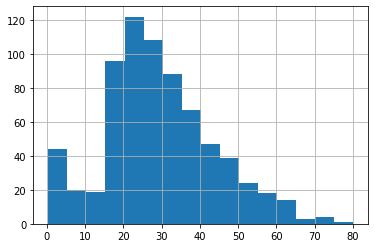

In [9]:
data['Age'].hist(bins=16);

In [10]:
pd.concat([data['Age'].describe().rename('Age_overall'), 
           survivors['Age'].describe().rename('Age_surv'), 
           deceased['Age'].describe().rename('Age_deceased')], axis=1)

,Age_overall,Age_surv,Age_deceased
count,714.000000,290.000000,424.000000
mean,29.699118,28.343690,30.626179
std,14.526497,14.950952,14.172110
min,0.420000,0.420000,1.000000
25%,20.125000,19.000000,21.000000
50%,28.000000,28.000000,28.000000
75%,38.000000,36.000000,39.000000
max,80.000000,80.000000,74.000000


In [11]:
data['Age'].max()

80.0

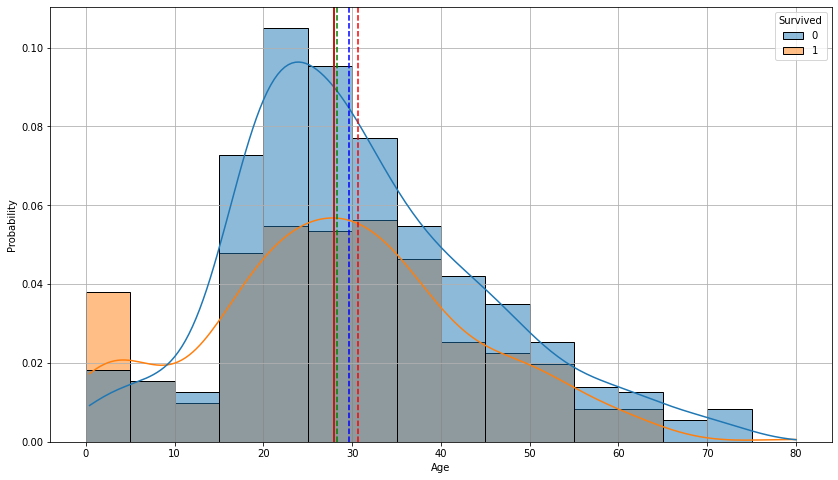

In [20]:
plt.figure(figsize=(14,8))
sns.histplot(data, x='Age', hue='Survived', bins=(range(0,80,5)), kde=True, stat='probability')

plt.axvline(data['Age'].mean(), c='blue', linestyle='--')
plt.axvline(data['Age'].median(), c='blue', linestyle='-')
plt.axvline(survivors['Age'].mean(), c='green', linestyle='--')
plt.axvline(survivors['Age'].median(), c='green', linestyle='-')
plt.axvline(deceased['Age'].mean(), c='red', linestyle='--')
plt.axvline(deceased['Age'].median(), c='red', linestyle='-')

plt.grid()
plt.xlabel('Age')
plt.ylabel('Probability');

We see that distributions of age in the total set and 'survived' and 'deceased' subsets are somewhat close. Their medians are totally equal and are 28 years. The most frequent age range is between 15 and 35 years for al 3 groups. Though while 'survived' age a is kind of plato in this range, there are considerable peaks of the 20-30 years interval for 'overall' and 'deceased'. The distribution of 'survived' age is more like normal one. So the probability of 20-30 years being dead after shipwreck is somewhat bigger, but not much. Why? Well, maybe it is because of similar behaviour of passionate young people trying to help everyone inspite of danger, and maybe just because of in general lower social status of such young people who travel in low-class and don't get a place in lifeboat.  
Another observation, which is more clear, is that children under 5 years old are much more likely to survive - their frequency in survivors is 3 times higher than in deceased and almost twice as high as in overall. Well, on one hand this is rather obvious - most people focus on saving lives of their children firstly. But this fact (together with one about survival fraction of women) tells us very important thing - the probability of survival very much depends not on person's survival skills and stamina (because they are rather low both for small children and women) but on whether he or she is 'allowed' to survive by other passengers. Lack of lifeboats, again.

< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

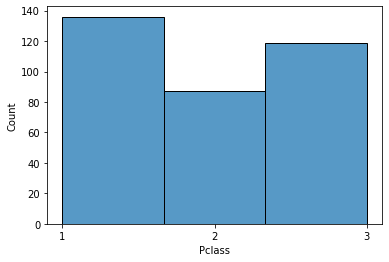

In [21]:
# Firstly, let's plot the quantity of survivers in every class.

sns.histplot(survivors['Pclass'], bins=3)
plt.xticks(ticks=[1, 2, 3]);

Wow, seems to be rather fair and equal! But...  Let's also plot the total quantity of passengers in every class.

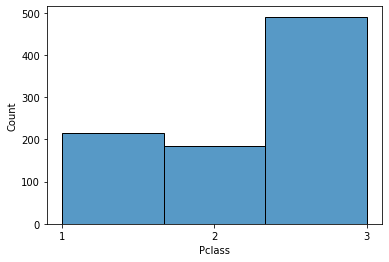

In [22]:
sns.histplot(data['Pclass'], bins=3)
plt.xticks(ticks=[1, 2, 3]);

Hm, there it is.. There are just a lot of passengers from 3rd class on board. More than half of them. And even more clearly:

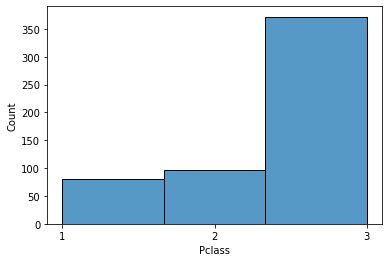

In [23]:
sns.histplot(deceased['Pclass'], bins=3)
plt.xticks(ticks=[1, 2, 3]);

Lots of people from the 3rd class died. What we really should plot is *percentage of passengers who survived in every class*.

In [24]:
class_by_safety = survivors['Pclass'].value_counts(sort=False) / data['Pclass'].value_counts(sort=False).sort_values()
class_by_safety

1    0.629630
2    0.472826
3    0.242363
Name: Pclass, dtype: float64

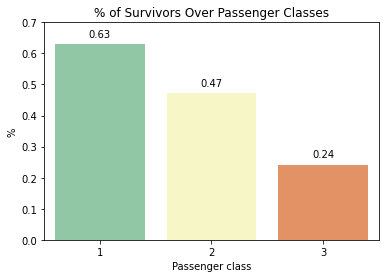

In [25]:
bar = sns.barplot(x=class_by_safety.index, y=class_by_safety, palette="Spectral_r")
for p in bar.patches:
    bar.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0., 10.), textcoords = 'offset points')
plt.xlabel('Passenger class')
plt.ylabel('%')
plt.title('% of Survivors Over Passenger Classes')
plt.ylim(0, 0.7);

Now we clearly see that **the 'safest' class is definitely the 1st**. Over 60% of its passengers stayed alive while only one quater from the 3rd class survived. Why? Well, maybe the most expensive tickets include some extra rescue equipment, or (more likely) the *priority of boarding life boats* was given to the rich. Or none of that, but simply 1st class cabins were the closest to boats in distance.

In [26]:
# Let's do the same thing for embarkation port feature.

embarked_by_safety = (survivors['Embarked'].value_counts(sort=False) /
                      data['Embarked'].value_counts(sort=False)).sort_values(ascending=False)
embarked_by_safety

C    0.553571
Q    0.389610
S    0.336957
Name: Embarked, dtype: float64

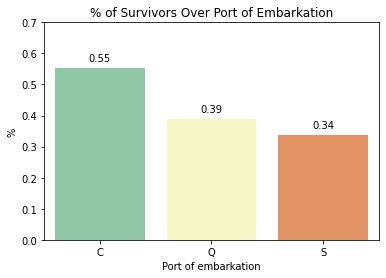

In [27]:
bar1 = sns.barplot(x=embarked_by_safety.index, y=embarked_by_safety, palette="Spectral_r")
for p in bar1.patches:
    bar1.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0., 10.), textcoords = 'offset points')
plt.xlabel('Port of embarkation')
plt.ylabel('%')
plt.title('% of Survivors Over Port of Embarkation')
plt.ylim(0, 0.7);

We see that there is some valueable correlation between the port of embarkation and survival chance. The 'safest' port is French Cherbourg while Irish Queenstown and English Southampton are relatively the same. Maybe the reason is that passengers from Cherbourg tended to travel by the highest 1st class more than others? Let's check.

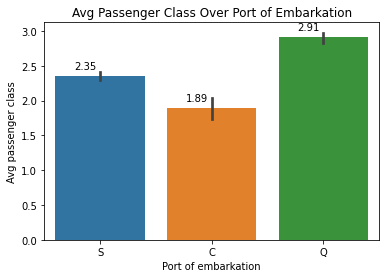

In [28]:
bar1 = sns.barplot(data=data, x='Embarked', y='Pclass')
for p in bar1.patches:
    bar1.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (-15., 10.), textcoords = 'offset points')
plt.xlabel('Port of embarkation')
plt.ylabel('Avg passenger class')
plt.title('Avg Passenger Class Over Port of Embarkation');

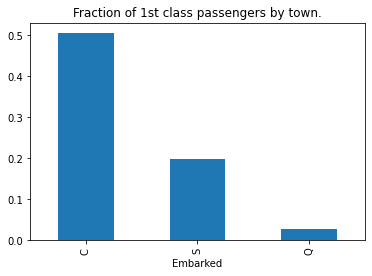

In [31]:
data.groupby('Embarked').apply(lambda x: x['Pclass'][x['Pclass'] == 1].sum() / len(x)).sort_values(ascending=False).plot.bar()
plt.title("Fraction of 1st class passengers by town.");

Yep, that's it. The fraction of 1st class passengers is the highest for Cherbourg. Half of them travelled by the 1st class. But the second place in surviving is not Southampton but Queenstown inspite of fraction of the 1st class.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [32]:
data.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [33]:
data.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

In [34]:
data[data['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Let's go through some of them.
- dropping rows. No way, because we have nearly 80% of missing values in 1 column (Cabin). We'll loose most of the data;
- dropping columns. Bad idea too, because columns seem to be important. While Age is not highly correlated with target by itself, it may be more useful in combinations. As for Cabin, we can't estimate its correlation with target right now (it is numerc var), but I expect it to be decently correlated, because cabin string contains deck code, and it may be very important.
- filling with mean/median. For age we can try it, but I think in this very case it's not the best way. Though correlation between age and the target is overall not very big (0.08) it will be better *to try to fill age with values predicted by submodel from such features as Pclass, SibSp and Parch, which are decently correlated with age*.
- cabin will be much more challenging to fill NaNs. We should parse it and see what we can do.   
- 'Embarked' column has very few NaNs (2), we can explore them manually. These two women travelled in one cabin with the same ticket, so they definitely were from the same town. The younger woman seems to have French name and women's cabin is 1st class, so we can assume they got on board in Cherbourg.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [43]:
data_e = data.copy()

In [44]:
# Nans' number

data_e.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [45]:
# Fill missing Age with mean value

data_e['Age'] = data_e['Age'].fillna(data_e['Age'].mean())

In [46]:
# One-hot-encoding 'Sex' column.

data_e = pd.get_dummies(data_e, columns=['Sex'])

In [47]:
# Selecting numerical features

features = data_e.drop(columns='Survived').select_dtypes(include='number').columns

In [48]:
features

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male'], dtype='object')

In [49]:
# The dataset is not very much unbalanced, but still it is slightly - classes are 0.38:0.62.
# So we'll try to use stratified splitting of our labeled data into train and validation subsets 
# instead of just using train_test_split()

tr_i, v_i = next(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
                 .split(X=data_e.drop(columns='Survived'), y=data_e['Survived']))

In [50]:
data_e = pd.concat((data_e.drop(columns='Survived'), data_e['Survived']), axis=1)

In [51]:
# splitting

train_data, val_data, train_labels, val_labels = data_e.iloc[tr_i, :-1], data_e.iloc[v_i, :-1], \
data_e.iloc[tr_i, -1], data_e.iloc[v_i, -1]

In [52]:
X = train_data[features]
y = train_labels

In [53]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression

In [54]:
# Set cross-validation strategy

cv = StratifiedShuffleSplit(test_size=0.3, random_state=SEED)

##### knn model training and evaluating

In [69]:
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=10))
cv_knn = cross_validate(pipe_knn, X, y, scoring='accuracy', cv=cv, return_estimator=True)

In [75]:
knn_val_accu = cv_knn['estimator'][np.argmax(cv_knn['test_score'])].score(val_data[features], val_labels)

##### logistic regression model training and evaluating

In [72]:
pipe_logreg = make_pipeline(MinMaxScaler(), LogisticRegression(solver='liblinear', penalty='l1', random_state=SEED))
cv_logreg = cross_validate(pipe_logreg, X, y, scoring='accuracy', cv=cv, return_estimator=True)

In [76]:
logreg_val_accu = cv_logreg['estimator'][np.argmax(cv_logreg['test_score'])].score(val_data[features], val_labels)

In [77]:
print(f"Knn model accuracy on validation set is {knn_val_accu}")
print(f"Logistic regression model accuracy on validation set is {logreg_val_accu}")

Knn model accuracy on validation set is 0.7597765363128491
Logistic regression model accuracy on validation set is 0.8100558659217877


Logistic regression seems to be better by now. But submission of this results to Kaggle says the contrary=)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

## Combining train and test data.

In [147]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [267]:
all_data = data.loc[:, data.columns != 'Survived'].append(test_data)

In [241]:
all_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## NaN Handling

In [90]:
all_data.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

#### Age with modelling

In [150]:
def fill_age_model(df):
    """Fills Nans in Age with values predicted by KNN model"""
    
    age_train = df[df["Age"].notna()].dropna()
    X_age_train = age_train.drop(columns='Age').select_dtypes(include='number')
    y_age_train = age_train['Age']
    X_age_pred = df[df["Age"].isna()].drop(columns=['Age']).select_dtypes(include='number')
    
    age_model = KNeighborsRegressor(n_neighbors=20)
    age_pipeline_scaled = make_pipeline(MinMaxScaler(), SelectFromModel(select_model), age_model)
    knn_param_grid = {'kneighborsregressor__n_neighbors': [1, 2, 3, 5, 30, 100]}
    knn_clf = GridSearchCV(make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_jobs=-1)), knn_param_grid)
    knn_clf.fit(X_age_train, y_age_train)
    y_age_pred = knn_clf.predict(X_age_pred)
    df.loc[df['Age'].isna(), 'Age'] = y_age_pred
    
    return df

#### Fare and Embarked

In [93]:
# Though Fare contains only 1 NaN, it is from test data, we can't drop this row, 
# so will fill it with median for that person's class.

all_data[all_data['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [94]:
all_data[all_data['Embarked'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [151]:
# As described in EDA section,

def fill_embark_fare(df):
    df.loc[df['Fare'].isna(), 'Fare'] = df.loc[df['Pclass'] == 3, 'Fare'].median()
    df.loc[df['Embarked'].isna(), 'Embarked'] = 'C'
    
    return df

## Feature engineering

#### one-hot for Embarked, Gender

In [152]:
def one_hot_emb_gen(df):
    df = pd.get_dummies(df, columns=['Embarked'])
    df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
    
    return df

#### Cabin-deck parsing and encoding

In [153]:
def deck(df):
    df['Deck'] = df['Cabin'].str[0]
    df.loc[df['Deck'].isna(), 'Deck'] = 'Unknown'
    df = pd.get_dummies(df, columns=['Deck'])
    
    return df

#### Adding Family Size

In [154]:
# Assuming that family on board consists of self, number of children/parents and Spouse/sisters/brothers, we get

def fam_size(df):
    df['Fam_size'] = 1 + df['Parch'] + df['SibSp']
    
    return df

#### Adding Fare per family member 

In [155]:
# May be useful considering those who travel with family

def fare_memb(df):
    df['Fare_per_mem'] = df['Fare'] / df['Fam_size']
    
    return df

#### Adding age * Pclass

In [100]:
all_data.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,-0.558629,0.178740,0.160238,0.221539,1.000000


In [237]:
# Age is highly correlated with Pclass and Parch/SibSp, let's create two  artificial features of their interaction.

def age_class(df):
    df['Age*Class'] = df['Age'] * df['Pclass']
    
    return df

In [266]:
def pclass_fare_fam(df):
    df['Fare/class/fam'] = df['Fare'] / (df['Pclass'] * df['Fam_size'])
    
    return df

#### Transforming Pclass into categorical

In [158]:
# In EDA section we saw that Pclass == 1st is very important surviving feature. But the difference between 1, 2 and 3
# is the same, unlike importance of the 1st class. So, though Pclass is numeric column, we'll try to make it categorical and
# encode it.

def pclass_to_cat(df):
    df['Pclass'] = df['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})
    df = pd.get_dummies(df, columns=['Pclass'])
    
    return df

#### Extracting titles from Names and grouping them

In [159]:
# Let's extract titles from the name variable (inspired by some kagglers)

def titles(df):
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'],
                                      'Miss/Mrs/Ms')
    df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 
                                      'Dr/Military/Noble/Clergy')
    df = pd.get_dummies(df, columns=['Title'])
    
    return df

#### Agregator function for convenience of iterative data prep

In [176]:
def handle_features(df):
    """Function-agregator for Nan handling and feature engineering"""
    
    df = fill_age_model(df)
    df = fill_embark_fare(df)
    
    df = one_hot_emb_gen(df)
    df = deck(df)
    df = fam_size(df)
    df = fare_memb(df)
    df = age_class(df)
    df = pclass_fare_fam(df)
    df = pclass_to_cat(df)
    df = titles(df)
    
    return df

In [242]:
all_data = handle_features(all_data)

In [243]:
all_data.head()

,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,...,Fare_per_mem,Age*Class,Fare/class/fam,Pclass_1st,Pclass_2nd,Pclass_3rd,Title_Dr/Military/Noble/Clergy,Title_Master,Title_Miss/Mrs/Ms,Title_Mr
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,...,3.62500,66.0,8.760417,0,0,1,0,0,0,1
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,0,...,35.64165,38.0,2540.654429,1,0,0,0,0,1,0
3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,...,7.92500,78.0,20.935208,0,0,1,0,0,1,0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,1,...,26.55000,35.0,1409.805000,1,0,0,0,0,1,0
5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,0,1,...,8.05000,105.0,21.600833,0,0,1,0,0,0,1


## Training and evaluating

In [244]:
features = all_data.select_dtypes(include='number').columns

In [245]:
features

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Sex_male', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Fam_size',
       'Fare_per_mem', 'Age*Class', 'Fare/class/fam', 'Pclass_1st',
       'Pclass_2nd', 'Pclass_3rd', 'Title_Dr/Military/Noble/Clergy',
       'Title_Master', 'Title_Miss/Mrs/Ms', 'Title_Mr'],
      dtype='object')

#### Splitting processed data back into train and test subsets and training into train and validation

In [246]:
data_processed, labels = all_data.loc[data.index, :], data.loc[data.index, 'Survived']
data_proc_w_labels = pd.concat((data_processed, labels), axis=1)

#### Dropping features with low feat-target correlation

In [247]:
corr = data_proc_w_labels.corr().abs().unstack()

In [248]:
corr = corr[corr.index.get_level_values(0) == 'Survived']
corr[corr >= 0.1]

Survived  Fare                 0.257307
          Embarked_C           0.174718
          Embarked_S           0.155660
          Sex_male             0.543351
          Deck_B               0.175095
          Deck_C               0.114652
          Deck_D               0.150716
          Deck_E               0.145321
          Deck_Unknown         0.316912
          Fare_per_mem         0.221600
          Age*Class            0.323307
          Fare/class/fam       0.126219
          Pclass_1st           0.285904
          Pclass_3rd           0.322308
          Title_Miss/Mrs/Ms    0.540769
          Title_Mr             0.549199
          Survived             1.000000
dtype: float64

In [249]:
features = corr[corr >= 0.1].index.get_level_values(1).tolist()
features.remove('Survived')

In [250]:
features

['Fare',
 'Embarked_C',
 'Embarked_S',
 'Sex_male',
 'Deck_B',
 'Deck_C',
 'Deck_D',
 'Deck_E',
 'Deck_Unknown',
 'Fare_per_mem',
 'Age*Class',
 'Fare/class/fam',
 'Pclass_1st',
 'Pclass_3rd',
 'Title_Miss/Mrs/Ms',
 'Title_Mr']

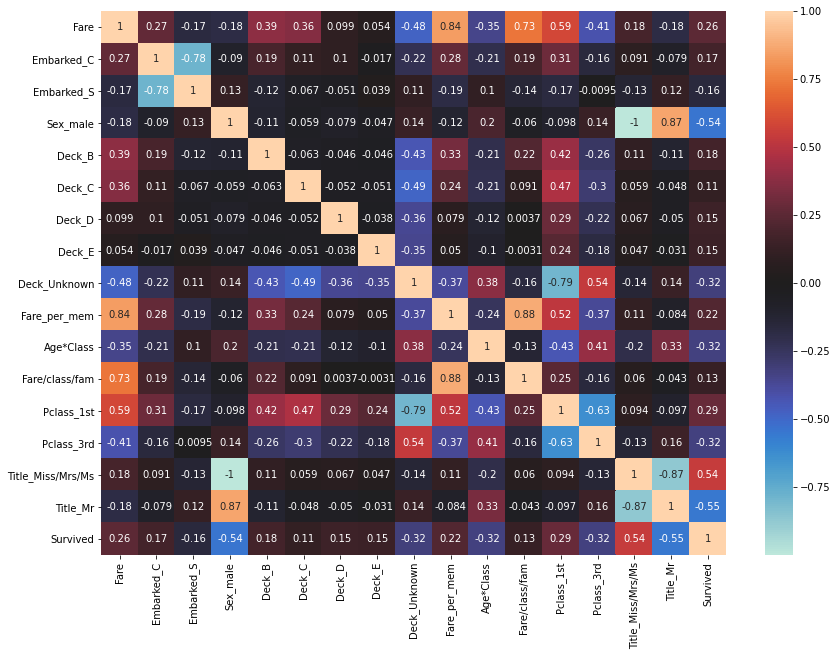

In [251]:
# Let's have a look on our final features heatmap

plt.figure(figsize=(14,10))
sns.heatmap(pd.concat((data_processed[features], labels), axis=1).corr(), annot=True, center=0);

#### preparing subsets

In [252]:
train_data, val_data, train_labels, val_labels = data_processed.iloc[tr_i, :], data_processed.iloc[v_i, :], \
labels.iloc[tr_i], labels.iloc[v_i]

In [253]:
X_train = train_data[features]
y_train = train_labels

X_val = val_data[features]
y_val = val_labels

#### Knn

In [254]:
# We will use knn model with normalizing and feature selection

knn_param_grid = {'kneighborsclassifier__n_neighbors': [1,3,7,10,20,30,40,50,60,70,80,90,100]}
knn_clf = GridSearchCV(make_pipeline(MinMaxScaler(), SelectFromModel(select_model), 
                                     KNeighborsClassifier(n_jobs=-1)), knn_param_grid)

In [255]:
knn_clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('selectfrommodel',
                                        SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                     random_state=18,
                                                                                     solver='liblinear'))),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 7, 10, 20,
                                                               30, 40, 50, 60,
                                                               70, 80, 90,
                                                               100]})

In [256]:
knn_clf.best_score_

0.8216487737614498

In [257]:
knn_clf.best_params_

{'kneighborsclassifier__n_neighbors': 7}

In [258]:
# There are features 'killed' by lasso selector in our pipeline

for i, feat in enumerate(knn_clf.best_estimator_.named_steps['selectfrommodel'].estimator_.coef_[0]):
    if feat == 0:
        print(features[i])

Fare
Sex_male
Fare/class/fam


In [272]:
# And these turned to be the most useful

for i, feat in enumerate(knn_clf.best_estimator_.named_steps['selectfrommodel'].estimator_.coef_[0]):
    if feat != 0:
        print(*(features[i], round(feat, 4)))

Embarked_C 0.0639
Embarked_S -0.1889
Deck_B 0.0633
Deck_C -0.0406
Deck_D 0.585
Deck_E 1.2169
Deck_Unknown -0.4255
Fare_per_mem 0.5089
Age*Class -0.7538
Pclass_1st 0.1646
Pclass_3rd -1.0448
Title_Miss/Mrs/Ms 1.3326
Title_Mr -1.4714


In [259]:
knn_clf.score(X_val, y_val)

0.776536312849162

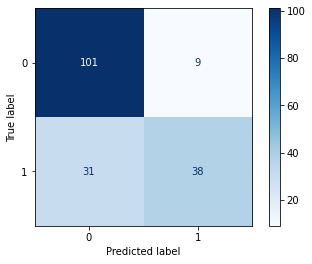

In [260]:
disp = plot_confusion_matrix(knn_clf, X_val, y_val,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [216]:
# We have somewhat better validation score than initial model's was. Lets make predictions and submit.

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [127]:
# Defining data to be predicted on.

X_test = all_data.loc[test_data.index, features]

In [128]:
# re-fitting the best estimator found by grid-search on the whole training set.

knn_clf.best_estimator_.fit(data_processed[features], labels)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=18,
                                                              solver='liblinear'))),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=7))])

In [129]:
# predicting target

target_pred_knn = knn_clf.best_estimator_.predict(X_test)

In [131]:
# form a dataframe and make a csv file from it

submit_df_knn = pd.DataFrame({'Survived': target_pred_knn}, index=test_data.index)
submit_df_knn.sum()

Survived    138
dtype: int64

In [132]:
submit_df_knn.to_csv(path_or_buf=os.path.join(PATH, 'titanic', 'titanic_submit_knn.csv'))

Best Kaggle Titanic submit:  0.78947  
Kaggle nick: Andrei Drabkin